## Технологии машинного обучения

## Практическая 3. Классификация

### Студент: Кирилл Захаров

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. 

**Обратите внимание**, что в каждом разделе практического задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [3]:
X.shape

(10000, 10)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1.5 балла)__

Обучите метод опорных векторов. Линейный вариант без ядрового перехода соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.metrics import make_scorer

In [5]:
svc = SVC(kernel='linear', C=1, probability=True, random_state=5)

In [6]:
svc.fit(X_train, y_train)

SVC(C=1, kernel='linear', probability=True, random_state=5)

In [7]:
svc.score(X_test, y_test) #accuracy

0.7753333333333333

In [8]:
def score_fun(X, y):
    precision, recall, thresholds = metrics.precision_recall_curve(X, y)
    return metrics.auc(recall, precision)

auc_pr = make_scorer(score_fun, greater_is_better=True)

In [9]:
clf = GridSearchCV(estimator=svc, param_grid={'C': np.linspace(1e-2, 5, 10)}, cv=4, scoring=auc_pr)

In [10]:
clf.fit(X_train, y_train) 

GridSearchCV(cv=4,
             estimator=SVC(C=1, kernel='linear', probability=True,
                           random_state=5),
             param_grid={'C': array([0.01      , 0.56444444, 1.11888889, 1.67333333, 2.22777778,
       2.78222222, 3.33666667, 3.89111111, 4.44555556, 5.        ])},
             scoring=make_scorer(score_fun))

In [11]:
clf.best_score_ 

0.8355806069226535

In [12]:
clf.best_estimator_.C  

0.5644444444444445

In [13]:
# clf = GridSearchCV(estimator=svc, param_grid={'C': np.linspace(1e-2, 5, 10)}, cv=4,\
#                    scoring='average_precision')

In [14]:
# clf.fit(X_train, y_train) 

In [15]:
svc = clf.best_estimator_

На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

In [16]:
precision, recall, trh = metrics.precision_recall_curve(y_test, svc.predict_proba(X_test)[:,1])

In [17]:
fp, tp, trh2 = metrics.roc_curve(y_test, svc.predict_proba(X_test)[:,1])

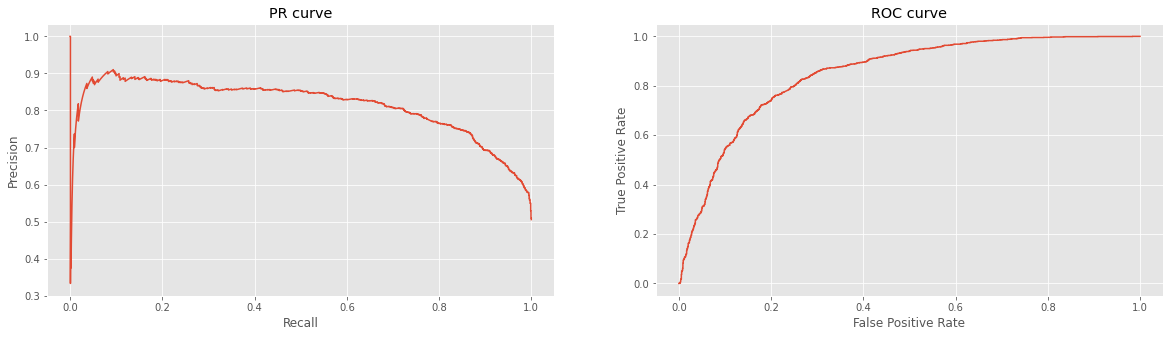

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].plot(recall, precision)
axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')
axs[0].set_title('PR curve')

axs[1].plot(fp, tp)
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC curve')


plt.show()

In [19]:
print(f'AUC-ROC = {round(metrics.roc_auc_score(y_test, svc.predict_proba(X_test)[:, 1]), 5)}\nAUC-PR = \
{round(metrics.auc(recall, precision), 5)}')

AUC-ROC = 0.8479
AUC-PR = 0.81488


#### По показателям AUC, классификатор показывает не плохие результаты вышу 0.5

In [20]:
from sklearn.dummy import DummyClassifier

In [21]:
dummy_clf = DummyClassifier(strategy='uniform', random_state=5)
dummy_clf.fit(X_train, y_train)

DummyClassifier(random_state=5, strategy='uniform')

In [22]:
dummy_clf.predict(X_test)

array([1, 0, 1, ..., 1, 0, 1])

In [23]:
precision_d, recall_d, trh_d = metrics.precision_recall_curve(y_test, dummy_clf.predict(X_test))

In [24]:
print(f'AUC-ROC = {round(metrics.roc_auc_score(y_test, dummy_clf.predict(X_test)), 5)}\nAUC-PR = \
{round(metrics.auc(recall_d, precision_d), 5)}')

AUC-ROC = 0.50135
AUC-PR = 0.62985


#### Относительно, случайного классификатора, метод опорных векторов показывает лучший результат.

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества.

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
log_reg = LogisticRegression(C=1, penalty='l2', random_state=5)

In [27]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=1, random_state=5)

In [28]:
log_reg.score(X_test, y_test) #accuracy

0.7713333333333333

In [29]:
clf = GridSearchCV(estimator=log_reg, param_grid={'C': np.linspace(1e-2, 5, 50)}, cv=4, scoring=auc_pr)

In [30]:
clf.fit(X_train, y_train) 

GridSearchCV(cv=4, estimator=LogisticRegression(C=1, random_state=5),
             param_grid={'C': array([0.01      , 0.11183673, 0.21367347, 0.3155102 , 0.41734694,
       0.51918367, 0.62102041, 0.72285714, 0.82469388, 0.92653061,
       1.02836735, 1.13020408, 1.23204082, 1.33387755, 1.43571429,
       1.53755102, 1.63938776, 1.74122449, 1.84306122, 1.94489796,
       2.04673469, 2.14857143, 2.25040816, 2.3522449 , 2.45408163,
       2.55591837, 2.6577551 , 2.75959184, 2.86142857, 2.96326531,
       3.06510204, 3.16693878, 3.26877551, 3.37061224, 3.47244898,
       3.57428571, 3.67612245, 3.77795918, 3.87979592, 3.98163265,
       4.08346939, 4.18530612, 4.28714286, 4.38897959, 4.49081633,
       4.59265306, 4.6944898 , 4.79632653, 4.89816327, 5.        ])},
             scoring=make_scorer(score_fun))

In [31]:
clf.best_score_ 

0.8342550398299848

In [32]:
clf.best_estimator_.C  

1.2320408163265306

In [33]:
log_reg = clf.best_estimator_

In [34]:
precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict_proba(X_test)[:,1])

In [35]:
fp, tp, trh2 = metrics.roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])

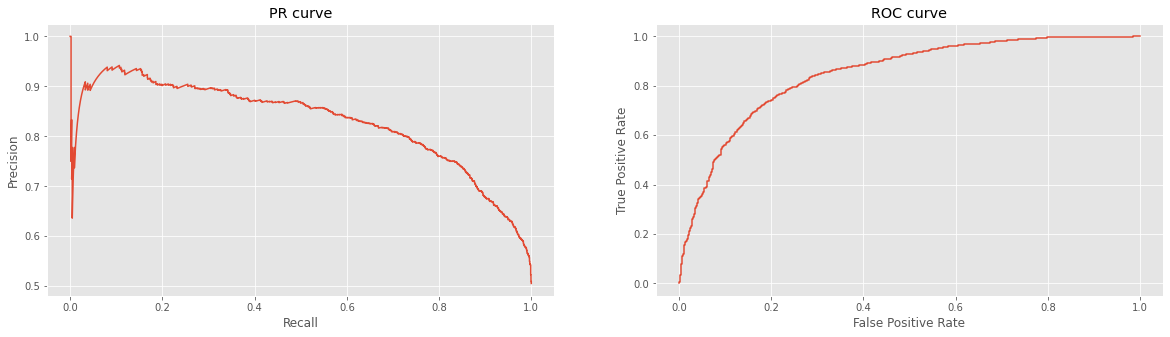

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].plot(recall, precision)
axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')
axs[0].set_title('PR curve')

axs[1].plot(fp, tp)
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC curve')


plt.show()

In [37]:
print(f'AUC-ROC = {round(metrics.roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]), 5)}\nAUC-PR = \
{round(metrics.auc(recall, precision), 5)}')

AUC-ROC = 0.84787
AUC-PR = 0.82912


#### По результатам метрик качества логистическая регрессия показала себя лучше по AUC-PR и почти одинаково с методом опорных векторов по AUC-ROC

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [47]:
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0,
    random_state=555)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=555)

In [48]:
svc2 = SVC(kernel='linear', C=1, probability=True, random_state=555)

In [49]:
svc2.fit(X_train, y_train)

SVC(C=1, kernel='linear', probability=True, random_state=555)

In [50]:
svc2.support_vectors_

array([[-0.38642845, -0.76543688],
       [-0.27935673, -0.74159156],
       [-0.51523265, -0.70758475],
       ...,
       [ 0.50416278,  0.34781344],
       [ 0.46261544,  0.98254097],
       [-0.14294346,  0.48758003]])

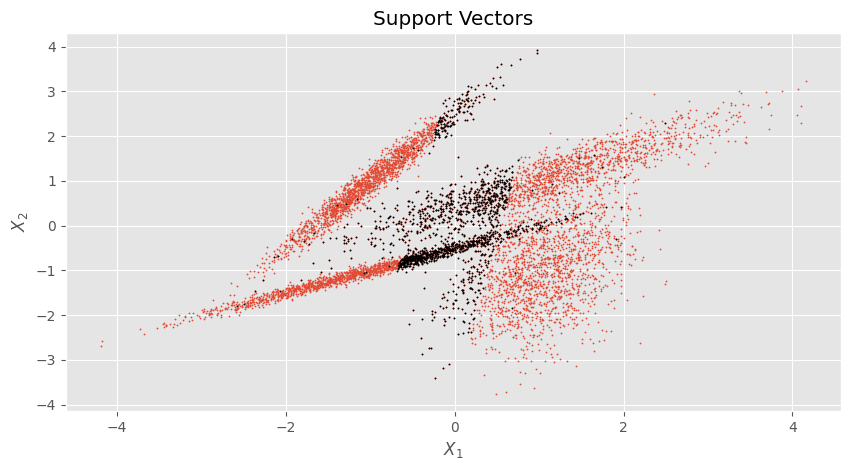

In [51]:
support_vectors = svc2.support_vectors_

plt.subplots(figsize=(10, 5), dpi=100)

plt.scatter(X_train[:,0], X_train[:,1], s=0.6)
plt.scatter(support_vectors[:,0], support_vectors[:,1], color='black', s=0.6)

plt.title('Support Vectors')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')

plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [52]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) # - -> +
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) #min -> mean
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [53]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

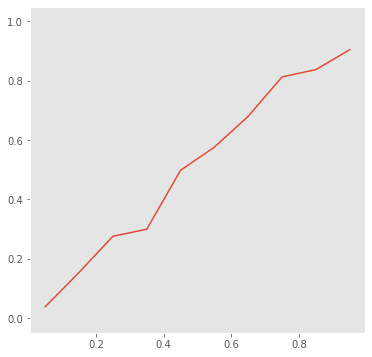

In [54]:
plot_calibration_curve(y_test, log_reg.predict_proba(X_test)[:, 1])

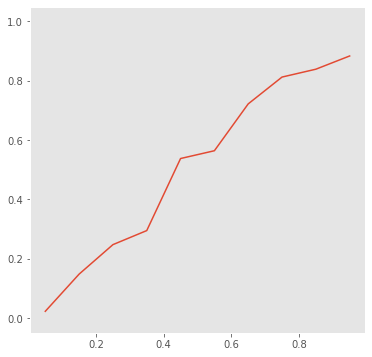

In [55]:
plot_calibration_curve(y_test, svc.predict_proba(X_test)[:, 1])

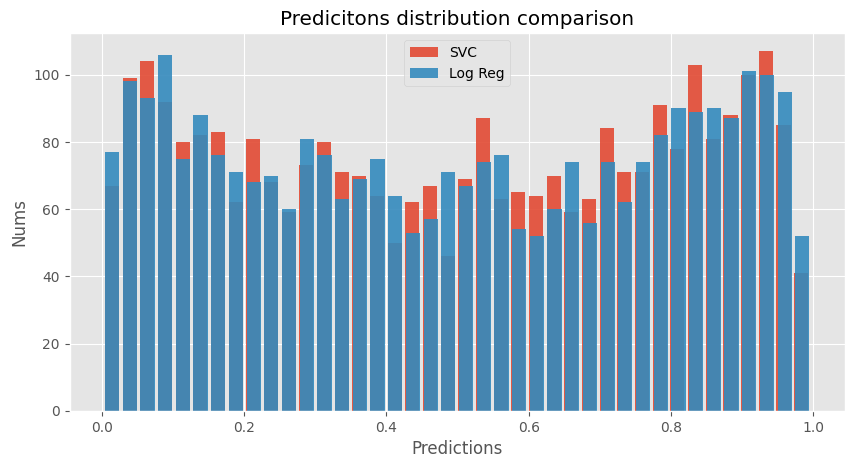

In [59]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.hist(svc.predict_proba(X_test)[:, 1], alpha=0.9, bins=40, rwidth=0.8, label='SVC')
plt.hist(log_reg.predict_proba(X_test)[:, 1], alpha=0.9, bins=40, rwidth=0.8, label='Log Reg')

plt.legend()
plt.xlabel('Predictions')
plt.ylabel('Nums')
plt.title('Predicitons distribution comparison')
plt.show()

#### По гистограмме классификаторы отличаются не сильно, однако можно заметить, что SVC имеет больше значений на отрезке [0.5, 1], в то время как логистическая регрессия наоборот. Соответсвенно SVC, дает больше предсказаний в сторону 1.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [60]:
from sklearn.calibration import CalibratedClassifierCV

In [61]:
calibrated_clf = CalibratedClassifierCV(svc, cv=5)

In [62]:
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=SVC(C=0.5644444444444445, kernel='linear',
                                     probability=True, random_state=5))

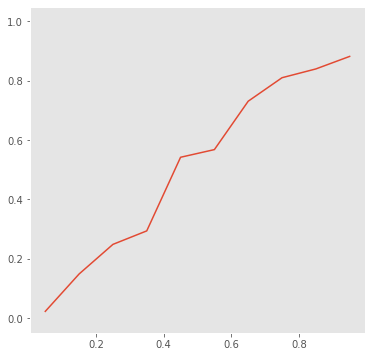

In [63]:
plot_calibration_curve(y_test, calibrated_clf.predict_proba(X_test)[:, 1])

#### Почти не дало никакого улучшения

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [65]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
# !unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [66]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [68]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1],\
                                                    test_size=0.25, random_state=777, stratify=df.iloc[:,-1])

Отбросил признак contact, так как там всего два значения, какой телефон, по моему мнению это не особо сказывается на результате.

In [69]:
X_train = X_train.drop('contact', axis=1)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: AUC-PR лучше работает с положительными классами и лучше работает с несбалансирвоанными выборками.

In [70]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import copy
import time

In [71]:
enc = OrdinalEncoder()

In [72]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'month', 'day_of_week', 'poutcome', 'y']

In [73]:
df = df.drop('contact', axis=1)

st = time.time()

df1 = copy.deepcopy(df)
df1[cat_columns] = enc.fit_transform(df[cat_columns])

X_train, X_test, y_train, y_test = train_test_split(df1.iloc[:,:-1], df1.iloc[:,-1],\
                                                    test_size=0.25, random_state=777, stratify=df1.iloc[:,-1])
# y_train = enc.fit_transform(y_train.values.reshape(-1, 1))

log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

et = time.time()

In [74]:
et - st

0.21932220458984375

In [75]:
# precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict_proba(X_test)[:,1])
precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict(X_test))

In [76]:
metrics.auc(recall, precision)

0.5575845908441447

__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [77]:
enc = OneHotEncoder()

In [78]:
# df = df.drop('contact', axis=1)

st = time.time()

df1 = copy.deepcopy(df)
df2 = pd.DataFrame(enc.fit_transform(df1[cat_columns]).toarray())
df1 = pd.concat([df1, df2], axis=1)
df1.columns = df1.columns.astype(str)
df1 = df1.drop(columns=cat_columns[:-1], axis=1)
df1['y'] = df['y'].replace({'no': 0, 'yes': 1})

X_train, X_test, y_train, y_test = train_test_split(df1[np.setdiff1d(df1.columns, 'y')], df1['y'],\
                                                    test_size=0.25, random_state=777, stratify=df1['y'])
# y_train = enc.fit_transform(y_train.values.reshape(-1, 1))

log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

et = time.time()

In [79]:
et - st

0.30144309997558594

In [80]:
# precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict_proba(X_test)[:,1])
precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict(X_test))

In [81]:
metrics.auc(recall, precision)

0.9991394148020654

In [82]:
df1.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [83]:
log_reg.predict(X_test).sum()

1162

In [84]:
y_test.sum()

1160

Как можно было заметить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


In [85]:
st = time.time()

df3 = copy.deepcopy(df)
df3['y'] = df3['y'].replace({'no': 0, 'yes': 1})


for i in cat_columns[:-1]:
    mean_vals = df3.groupby(i)['y'].mean()
    df3[i] = df3[i].replace(dict(list(zip(mean_vals.index.values,mean_vals.values))))
    
X_train, X_test, y_train, y_test = train_test_split(df3[np.setdiff1d(df3.columns, 'y')], df3['y'],\
                                                    test_size=0.25, random_state=777, stratify=df3['y'])

log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

et = time.time()

In [86]:
df3.head()

,age,job,marital,education,default,housing,loan,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,0.100000,0.101573,0.102490,0.12879,0.108796,0.113402,0.064347,0.099483,261,1,999,0,0.088322,1.1,93.994,-36.4,4.857,5191.0,0
1,57,0.081381,0.101573,0.108355,0.05153,0.108796,0.113402,0.064347,0.099483,149,1,999,0,0.088322,1.1,93.994,-36.4,4.857,5191.0,0
2,37,0.081381,0.101573,0.108355,0.12879,0.116194,0.113402,0.064347,0.099483,226,1,999,0,0.088322,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0.129726,0.101573,0.082024,0.12879,0.108796,0.113402,0.064347,0.099483,151,1,999,0,0.088322,1.1,93.994,-36.4,4.857,5191.0,0
4,56,0.081381,0.101573,0.108355,0.12879,0.108796,0.109315,0.064347,0.099483,307,1,999,0,0.088322,1.1,93.994,-36.4,4.857,5191.0,0


In [87]:
et - st

0.2585158348083496

In [88]:
# precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict_proba(X_test)[:,1])
precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict(X_test))

In [89]:
metrics.auc(recall, precision)

0.5562008886505406

In [90]:
log_reg.predict(X_test).sum()

722

In [91]:
y_test.sum()

1160

Получилось хуже, чем в предыдущих случаях. Время обучение быстрее чем Onehot, но медленне Ordinal.

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [93]:
st = time.time()

df3 = copy.deepcopy(df)
df3['y'] = df3['y'].replace({'no': 0, 'yes': 1})


for i in cat_columns[:-1]:
    mean_vals = df3.groupby(i)['y'].mean()
    df3[i] = df3[i].replace(dict(list(zip(mean_vals.index.values, mean_vals.values))))
    
    df3[i] += np.random.normal(0, 0.5, size=len(df3))
    
X_train, X_test, y_train, y_test = train_test_split(df3[np.setdiff1d(df3.columns, 'y')], df3['y'],\
                                                    test_size=0.25, random_state=777, stratify=df3['y'])

log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

et = time.time()

In [94]:
et - st

0.2610180377960205

In [95]:
# precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict_proba(X_test)[:,1])
precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict(X_test))

In [96]:
metrics.auc(recall, precision)

0.5549415524627379

Выводы: Качество не сильно хуже, а иногда даже лучше (зависит от случайного фактора), по скорости одинаково

__Задание 7 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



#### Всего 78 уникальных значений

In [97]:
len(df['age'].value_counts())

78

In [103]:
cat_columns.insert(0, 'age')

In [105]:
st = time.time()

df3 = copy.deepcopy(df)
df3['y'] = df3['y'].replace({'no': 0, 'yes': 1})


for i in cat_columns[:-1]:
    mean_vals = df3.groupby(i)['y'].mean()
    df3[i] = df3[i].replace(dict(list(zip(mean_vals.index.values, mean_vals.values))))
    
    df3[i] += np.random.normal(0, 0.5, size=len(df3))
    

    
X_train, X_test, y_train, y_test = train_test_split(df3[np.setdiff1d(df3.columns, 'y')], df3['y'],\
                                                    test_size=0.25, random_state=777, stratify=df3['y'])

log_reg = LogisticRegression(solver='newton-cholesky')
log_reg.fit(X_train, y_train)

et = time.time()

In [106]:
# precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict_proba(X_test)[:,1])
precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict(X_test))

In [107]:
metrics.auc(recall, precision)

0.5583508835025477

Качество улучшилось

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [108]:
df3 = copy.deepcopy(df)

df3['month'] = df3['month'].replace(dict(list(zip(df3['month'].unique(), [5, 6, 7, 8, 10, 11, 12, 3, 4, 9]))))
df3['day_of_week'] = df3['day_of_week'].replace(dict(list(zip(df3['day_of_week'].unique(), range(5)))))

In [109]:
df3['y'] = df3['y'].replace({'no': 0, 'yes': 1})


for i in cat_columns[:-1]:
    mean_vals = df3.groupby(i)['y'].mean()
    df3[i] = df3[i].replace(dict(list(zip(mean_vals.index.values, mean_vals.values))))
    
#     df3[i] += np.random.normal(0, 0.1, size=len(df3))
    

    
X_train, X_test, y_train, y_test = train_test_split(df3[np.setdiff1d(df3.columns, 'y')], df3['y'],\
                                                    test_size=0.25, random_state=777, stratify=df3['y'])

log_reg = LogisticRegression(solver='newton-cholesky')
log_reg.fit(X_train, y_train)

et = time.time()

In [110]:
# precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict_proba(X_test)[:,1])
precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict(X_test))

In [111]:
metrics.auc(recall, precision)

0.5631032688866153

Стало значительней лучше

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ У счетчиков есть преимущество по скорости кодирования и значительно меньше трата по памяти, но требуется обращаться к целевой переменной. OneHot кодирование дает лучше результат по качеству модели, но перегружает память при большом числе значений категориальных признаков. Счетчики также могут дать хороший результат по метрикам если правильно интерпретировать признаки, и кодировать соответсвующим образом.

# Часть 2. Отбор признаков

**Задание 8 (1 балл)**

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [112]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [113]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan',
               'contact', 'month', 'day_of_week','poutcome']

In [114]:
X1 = pd.get_dummies(X[cat_columns])
X = pd.concat([X1, X.drop(cat_columns, axis=1)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

In [115]:
X.shape

(41188, 62)

#### Получили всего 62 признака

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [116]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [117]:
precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict_proba(X_test)[:,1])
# precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict(X_test))
auc_pr_1 = metrics.auc(recall, precision)

In [118]:
auc_pr_1

0.44231037743944385

### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 9 (1 балл).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [119]:
st = time.time()

idx_feat = np.array(sorted(list(zip(np.abs(log_reg.coef_[0]), np.arange(len(log_reg.coef_[0])))),\
       key=lambda x: x[0], reverse=True)[:40])[:,1].astype(int)

X2 = X.iloc[:, idx_feat]

et = time.time()

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=777, stratify=y)

log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict_proba(X_test)[:,1])
# precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict(X_test))
auc_pr_2 = metrics.auc(recall, precision)

In [120]:
auc_pr_2

0.44551096861258055

In [121]:
et - st #время отбора признаков

0.005521297454833984

#### Качество изменилось в лучшую сторону

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [122]:
from sklearn.preprocessing import MinMaxScaler

#### Нормированный вариант на всех признаках

In [123]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

cont_cols = np.setdiff1d(X.columns, cat_columns)

scaler = MinMaxScaler()

X[cont_cols] = scaler.fit_transform(X[cont_cols])

X1 = pd.get_dummies(X[cat_columns])
X = pd.concat([X1, X.drop(cat_columns, axis=1)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict_proba(X_test)[:,1])
auc_pr_scaled1 = metrics.auc(recall, precision)

In [124]:
auc_pr_scaled1

0.44943131805807623

#### С отбором

In [125]:
st = time.time()

idx_feat = np.array(sorted(list(zip(np.abs(log_reg.coef_[0]), np.arange(len(log_reg.coef_[0])))),\
       key=lambda x: x[0], reverse=True)[:40])[:,1].astype(int)

X2 = X.iloc[:, idx_feat]

et = time.time()

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=777, stratify=y)

log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict_proba(X_test)[:,1])
# precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict(X_test))
auc_pr_scaled2 = metrics.auc(recall, precision)

In [126]:
auc_pr_scaled2

0.4495496953545842

In [127]:
et-st

0.0036978721618652344

Получилось лучше, по времени затраты не сильно выше

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 10 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [128]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

cont_cols = np.setdiff1d(X.columns, cat_columns)

scaler = MinMaxScaler()

X[cont_cols] = scaler.fit_transform(X[cont_cols])

X1 = pd.get_dummies(X[cat_columns])
X = pd.concat([X1, X.drop(cat_columns, axis=1)], axis=1)

st = time.time()

idx_one = np.where(y_train.values == True)[0]
idx_zero = np.where(y_train.values == False)[0]

n_one = len(idx_one)
n_zero = len(idx_zero)

# Прибавляем константу 1e-8 т.к. у признака month_sep в знаменателе 0.
t_stat = np.abs(X.iloc[idx_one].mean() - X.iloc[idx_zero].mean())/\
        (np.sqrt((n_one*X.iloc[idx_one].var() + n_zero*X.iloc[idx_zero].var()) / (n_one + n_zero))+1e-8)

X = X.loc[:, t_stat.sort_values(ascending=False)[:40].index.values]

et = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict_proba(X_test)[:,1])
auc_pr_filter = metrics.auc(recall, precision)


In [129]:
auc_pr_filter

0.4401535126587686

In [130]:
et-st

0.028271913528442383

Результат хуже

### Методы-обёртки

__Задание 11 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [131]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

cont_cols = np.setdiff1d(X.columns, cat_columns)

scaler = MinMaxScaler()

X[cont_cols] = scaler.fit_transform(X[cont_cols])

X1 = pd.get_dummies(X[cat_columns])
X = pd.concat([X1, X.drop(cat_columns, axis=1)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=777, stratify=y_train)


In [132]:
st = time.time()

errors = []

for col in X_train_1.columns:
    log_reg = LogisticRegression(solver='liblinear')
    log_reg.fit(X_train_1.drop(col, axis=1), y_train_1)

    precision, recall, trh = metrics.precision_recall_curve(y_val,\
                                                log_reg.predict_proba(X_val.drop(col, axis=1))[:,1])
    auc_pr_scaled1 = metrics.auc(recall, precision)
    
    errors.append(auc_pr_scaled1)

idx = np.array(sorted(np.array(list(zip(np.arange(len(errors)), errors))),\
                      key=lambda x: x[1], reverse=True)[:40]).T[0].astype(int)

et = time.time()

In [133]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train.iloc[:,idx], y_train)

precision, recall, trh = metrics.precision_recall_curve(y_test, log_reg.predict_proba(X_test.iloc[:,idx])[:,1])
auc_pr_wrap = metrics.auc(recall, precision)

In [136]:
auc_pr_wrap

0.445966724142901

Отбор в таком случае занимает больше времени

In [135]:
et-st

5.787574052810669

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [137]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

cont_cols = np.setdiff1d(X.columns, cat_columns)

scaler = MinMaxScaler()

X[cont_cols] = scaler.fit_transform(X[cont_cols])

X1 = pd.get_dummies(X[cat_columns])
X = pd.concat([X1, X.drop(cat_columns, axis=1)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=777, stratify=y_train)


In [138]:
st = time.time()

errors = []
X_train_2 = X_train_1.iloc[:, 0]
X_val_2 =  X_val.iloc[:, 0]

k = 0

for col in X_train_1.columns[1:]:
    log_reg = LogisticRegression(solver='liblinear')
    
    X_train_2 = pd.concat([X_train_2, X_train_1[col]], axis=1)
    log_reg.fit(X_train_2, y_train_1)
    
    X_val_2 = pd.concat([X_val_2, X_val[col]], axis=1)

    precision, recall, trh = metrics.precision_recall_curve(y_val,\
                                                log_reg.predict_proba(X_val_2)[:,1])
    auc_pr_scaled1 = metrics.auc(recall, precision)
    
    k += 1
    errors.append(auc_pr_scaled1)

idx = np.array(sorted(np.array(list(zip(np.arange(len(errors)), errors))),\
                      key=lambda x: x[1], reverse=True)[:40]).T[0].astype(int)

et = time.time()

In [139]:
et-st

2.0080292224884033

In [161]:
np.array(errors)

array([0.25152784, 0.2521317 , 0.25246746, 0.32336422, 0.19189528,
       0.19197405, 0.1945858 , 0.20425515, 0.20062124, 0.20122574,
       0.20114759, 0.20034183, 0.17205171, 0.17204218, 0.1720407 ,
       0.17162348, 0.1720557 , 0.17067058, 0.17320537, 0.17335258,
       0.17436977, 0.17539238, 0.17539081, 0.19505273, 0.19496264,
       0.19497619, 0.19453956, 0.19473262, 0.19473702, 0.19529253,
       0.195249  , 0.19521211, 0.21690304, 0.21692556, 0.22343575,
       0.2296946 , 0.23458826, 0.24372528, 0.25406841, 0.27226881,
       0.27173776, 0.29423038, 0.29414234, 0.29422273, 0.29407243,
       0.30052917, 0.30072163, 0.30068327, 0.3006832 , 0.3030695 ,
       0.37814057, 0.37837594, 0.37846439, 0.38200888, 0.38678919,
       0.38849934, 0.41199378, 0.4322639 , 0.43623964, 0.43648045,
       0.4361693 ])

In [159]:
idx

array([59, 58, 60, 57, 56, 55, 54, 53, 52, 51, 50,  3, 49, 46, 47, 48, 45,
       41, 43, 42, 44, 39, 40, 38,  2,  1,  0, 37, 36, 35, 34, 33, 32,  7,
        9, 10,  8, 11, 29, 30])

Добавляя признаки, сначала AUC-PR снижался, однако при наборе достаточного числа полезных признаков стал повышаться.

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Лучше всего себя показал встроенный метод, на основе коэффицентов регресии с нормировкой признаков. Также это один из самых быстрых способов, поскольку мы не используем никаких расчетов дополнительно, а напрямую берем параметры модели и смотрим на их значения. Также быстрым способом является метод филтрации, так как мы считаем некоторую функцию по всем признакам сразу. Худший метод, это метод обертки, он занимает много времени, из-за циклов при отборе.

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 12 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [140]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

cont_cols = np.setdiff1d(X.columns, cat_columns)

scaler = MinMaxScaler()

X[cont_cols] = scaler.fit_transform(X[cont_cols])

X1 = pd.get_dummies(X[cat_columns])
X = pd.concat([X1, X.drop(cat_columns, axis=1)], axis=1)

In [141]:
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.model_selection import KFold

In [142]:
# kf = KFold(5, shuffle=True, random_state=500)

# log_reg = LogisticRegression(solver='liblinear')

# res = cross_val_predict(log_reg, X, y, cv=kf)

In [143]:
kf = KFold(5, shuffle=True, random_state=500)

In [144]:
predictions = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    log_reg = LogisticRegression(solver='liblinear')
    log_reg.fit(X.iloc[train_index], y.iloc[train_index])
    
    predictions.append(log_reg.predict(X.iloc[test_index]))

In [145]:
(np.array(list(map(sum, predictions)))*10).mean()

3174.0

In [146]:
(np.array(list(map(sum, predictions)))*10).std()

59.19459434779497

В среднем мы зараюотаем 2856 долларов

In [147]:
profit = np.array(list(map(sum, predictions)))*10 - list(map(sum, predictions))
profit

array([2763, 2844, 2862, 2916, 2898])

In [148]:
np.mean(profit)

2856.6

В среднем мы отдадим 317 долларов сотрудникам

In [149]:
np.mean(list(map(sum, predictions)))

317.4

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [150]:
predictions_noisy = []
for i in range(len(predictions)):
    predictions_noisy.append(np.array(predictions[i]) * np.random.uniform(0, 20, size=len(predictions[i])))

In [151]:
predictions_noisy = np.array(predictions_noisy)
predictions_noisy

<ipython-input-151-461ef11a89ce>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predictions_noisy = np.array(predictions_noisy)


array([array([0., 0., 0., ..., 0., 0., 0.]),
       array([0.        , 0.        , 0.        , ..., 5.49975908, 0.        ,
              0.        ])                                                    ,
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([ 0.        ,  0.        ,  0.        , ..., 10.89827393,
              19.88938821,  0.        ])                              ,
       array([0., 0., 0., ..., 0., 0., 0.])], dtype=object)

In [152]:
(np.array(list(map(sum, predictions_noisy)))).mean()

3104.56305370579

In [153]:
(np.array(list(map(sum, predictions_noisy)))).std()

53.61093501561903

In [154]:
profit = np.array(list(map(sum, predictions_noisy))) - list(map(sum, predictions))
profit

array([2746.21000482, 2745.75488203, 2775.65901485, 2879.26241463,
       2788.92895219])

In [155]:
np.mean(profit)

2787.16305370579

Сотрудникам отдадим столько же, однако теперь насколько прибыль велика зависит от того, сколько клиент принесет денег после звонка.